In [1]:
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.document_loaders import PyPDFLoader
from langchain.prompts import ChatPromptTemplate
from langchain_core.prompts import PromptTemplate
from llm_call import LLMCall
from embeddings import Embeddings
from operator import itemgetter

In [2]:
# Load PDF and split it into chunks
pdf_file = 'sample.pdf'
chunk_size = 1000
chunk_overlap = 200

loader = PyPDFLoader(pdf_file)
documents = loader.load()

# Split the document into manageable chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)
texts = text_splitter.split_documents(documents)

/Users/chirag/miniconda3/envs/LLMs-env/lib/python3.10/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [3]:
texts[0]

Document(metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 19.3 (Macintosh)', 'creationdate': '2024-06-18T14:09:48-07:00', 'moddate': '2024-06-18T14:10:14-07:00', 'trapped': '/False', 'source': 'sample.pdf', 'total_pages': 4, 'page': 0, 'page_label': '1'}, page_content='Before using iPhone, review the iPhone User Guide  at  \nsupport.apple.com/guide/iphone .\nSafety and Handling\nSee “Safety, handling, and support” in the iPhone  \nUser Guide .\nExposure to Radio Frequency\nOn iPhone, go to Settings > General > Legal &  \nRegulatory > RF Exposure. Or go to apple.com/  \nlegal/rfexposure .\nBattery and Charging\nAn iPhone battery should only be repaired by a trained \ntechnician to avoid battery damage, which could cause \noverheating, fire, or injury. Batteries should be recycled \nor disposed of separately from household waste and \naccording to local environmental laws and guidelines. For \ninformation about Apple lithium-ion batteries and battery \nservice a

In [4]:
len(texts)

8

In [5]:
# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""

prompt_decomposition = ChatPromptTemplate.from_template(template)

In [6]:
prompt_decomposition

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are a helpful assistant that generates multiple sub-questions related to an input question. \n\nThe goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n\nGenerate multiple search queries related to: {question} \n\nOutput (3 queries):'), additional_kwargs={})])

In [7]:
# LLM
open_ai_llm = LLMCall.azure_openai()

# Chain
generate_queries_decomposition = ( prompt_decomposition | open_ai_llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "Is there a warranty on the phone?"
questions = generate_queries_decomposition.invoke({"question":question})

In [8]:
questions

['1. What is the standard warranty period for smartphones from major manufacturers?',
 '2. How can I check if my phone is still under warranty?',
 '3. What types of damages are typically covered under a smartphone warranty?']

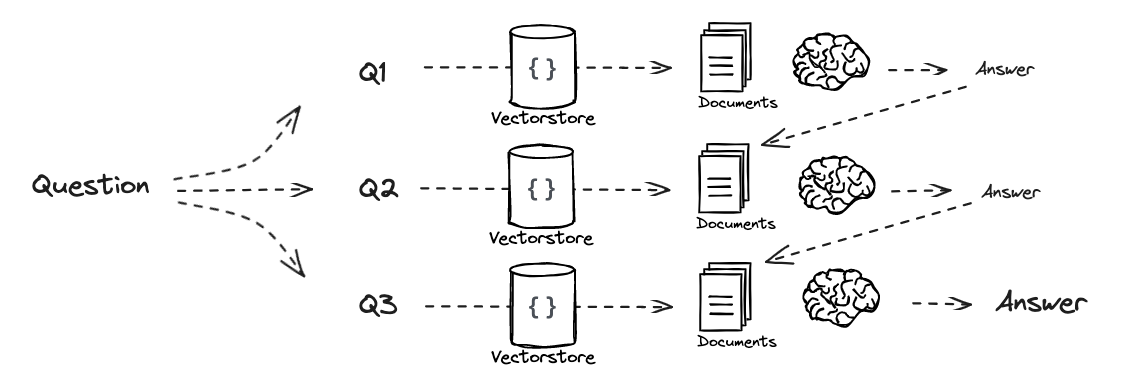

In [9]:
# 📝 Define the custom prompt template used in the final RAG stage

rag_template = """
You are a customer service agent for a apple mobile company.
Customer Query: \n --- \n {question} \n --- \n

You have been given the following information about the context.
Context: \n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}

The answer should be based on the context provided.
Your task is to answer the customer question based on the context provided. If the question is not related to the context, please say "I don't know or Do Not Answer it just say please ask me question related to Apple Mobiles only".
Do not make up any information or provide any personal opinions or experiences.
Please answer in a friendly and professional manner.
"""

In [10]:
decomposition_prompt = ChatPromptTemplate.from_template(rag_template)

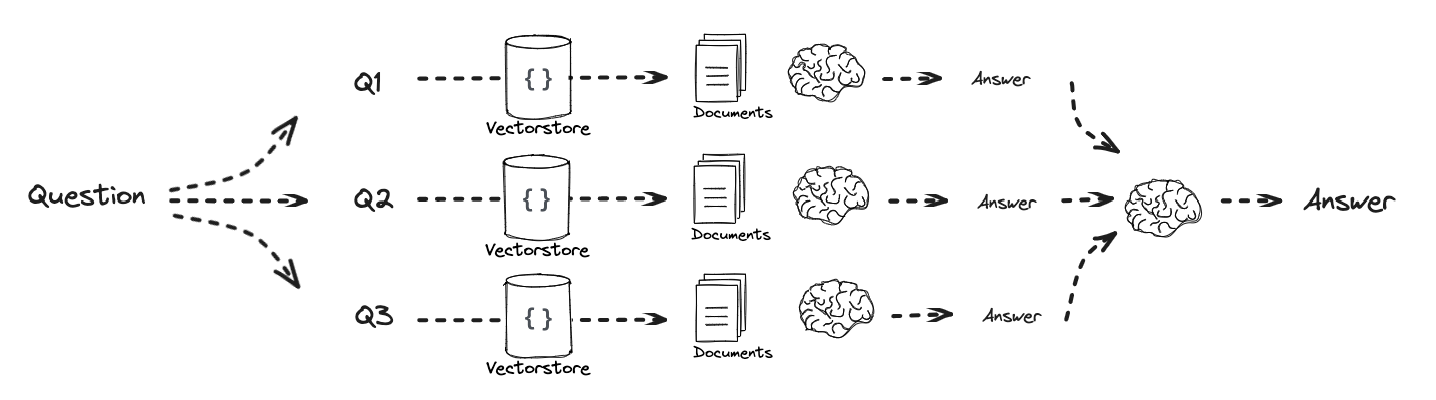

In [11]:
def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain,llm,retriever):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

In [12]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

In [18]:
# Prompt
final_template = """

You are a customer service agent for a apple mobile company.
Customer Query: {question}

You have been given the following set of Q+A pairs use the Answers as the context.
Context: {context}

Use the above context and any background question + answer pairs to answer the question: \n {question}

Answer:

The answer should be based on the context provided.
Your task is to answer the customer question based on the context provided. If the question is not related to the context, please say "I don't know or Do Not Answer it just say please ask me question related to Apple Mobiles only".
Do not make up any information or provide any personal opinions or experiences.
Please answer in a friendly and professional manner.
"""


## ☁️ Using Azure OpenAI for Embeddings & Generation

In [14]:
open_ai_embeddings = Embeddings.azure_openai()

vectorstore_openai = FAISS.from_documents(
    texts,
    open_ai_embeddings
)

azure_retriever = vectorstore_openai.as_retriever()

# 🤖 Initialize Azure OpenAI Chat Model (LLM)

open_ai_llm = LLMCall.azure_openai()

# prompt_rag_template = PromptTemplate.from_template(rag_template)
prompt_rag_template = hub.pull("rlm/rag-prompt")

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag_template, generate_queries_decomposition, open_ai_llm, azure_retriever)

context = format_qa_pairs(questions, answers)


/var/folders/39/wh_jffd90vv2lczbpfngvr200000gn/T/ipykernel_76972/1673753289.py:13: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)


In [21]:
final_prompt = ChatPromptTemplate.from_template(final_template)
final_rag_chain = (
    final_prompt
    | open_ai_llm
    | StrOutputParser()
)

ans = final_rag_chain.invoke({"context":context,"question":question})

In [22]:
ans

"Yes, smartphones typically come with a limited warranty that covers defects in materials and workmanship for a specified period, often one year. Some manufacturers may also offer extended warranties or service plans for additional coverage. However, it's important to note that warranties usually do not cover damage caused by normal wear and tear or misuse. If you have any further questions about your specific phone's warranty, feel free to ask!"

<!-- Font Awesome CDN (Add in <head> if not already included) -->
<link
  rel="stylesheet" 
  href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.5.0/css/all.min.css"
/>

<!-- Social Footer Section -->
<div style="
  background-color:rgb(199, 195, 195);
  padding: 40px 30px;
  border-radius: 20px;
  box-shadow: 0 4px 12px rgba(0,0,0,0.08);
  font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
  font-size: 18px;
  max-width: 900px;
  margin: 60px auto 30px;
  text-align: center;
  color: #444;
">
<!-- End of Notebook Note -->
  <h2 style="margin-bottom: 10px;">📘 End of Notebook</h2>
  <p style="color: #666; font-size: 14px;">
    Thank you for exploring! Feel free to connect via the links below.
  </p>

  <!-- Social Icons -->
<div style="
  display: flex;
  gap: 25px;
  align-items: center;
  flex-wrap: wrap;
  justify-content: center;
  margin-bottom: 25px;
">
  <!-- LinkedIn -->
  <a href="https://www.linkedin.com/in/ChiragB254" target="_blank" style="text-decoration: none; color: #0077b5;">
    <i class="fab fa-linkedin fa-lg"></i> LinkedIn
  </a>

  <!-- GitHub -->
  <a href="https://github.com/ChiragB254" target="_blank" style="text-decoration: none; color: #333;">
    <i class="fab fa-github fa-lg"></i> GitHub
  </a>

  <!-- Instagram -->
  <a href="https://www.instagram.com/data.scientist_chirag" target="_blank" style="text-decoration: none; color: #E1306C;">
    <i class="fab fa-instagram fa-lg"></i> Instagram
  </a>

  <!-- Email -->
  <a href="mailto:devchirag27@gmail.com" style="text-decoration: none; color: #D44638;">
    <i class="fas fa-envelope fa-lg"></i> Email
  </a>

  <!-- X (Twitter) -->
  <a href="https://x.com/ChiragB254" target="_blank" style="text-decoration: none; color: #000;">
    <i class="fab fa-x-twitter fa-lg"></i> X.com
  </a>
  </div>

  <p style="font-size: 13px; color: black; font-style: italic; margin-top: 8px;">
    <strong>Made with ❤️ by Chirag Bansal</strong>
  </p>
</div>

